In [ ]:
import pysm
import pysm.units as u

import matplotlib.pyplot as plt

import jax.numpy as np
from jax import grad, hessian
import jax

from scipy.optimize import minimize
import numpy as old_np
import healpy as hp
import emcee

from hoover.seds import FMatrix
from hoover.likelihood import LogProb
from hoover.tools import WhiteNoise
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
nside = 64
sky = pysm.Sky(nside=nside, preset_strings=["d1", "s1"])

In [3]:
freqs = np.array([27., 39., 93., 145., 225., 280.]).astype(np.float32) * u.GHz
sens = np.array([35., 21, 2.6, 3.3, 6.3, 16.]) * u.uK_CMB
sens = np.array([w.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(f)) for w, f in zip(sens, freqs)])

In [4]:
out = np.concatenate(list(sky.get_emission(f)[None, 1:, ...] for f in freqs))

In [5]:
noise = WhiteNoise(sens=sens)
noise_map = old_np.asarray(noise.map(nside))

In [6]:
cov = noise.get_pix_var_map(nside)

In [7]:
noisy_obs = noise_map + out

In [8]:
sed = FMatrix(['dustmbb', 'syncpl'])
parameters = {'nu': freqs.value, 'nu_ref_d': np.float32(353), 'nu_ref_s': np.float32(23.), 'beta_d': np.float32(1.5), 'beta_s': np.float32(-3.), 'T_d': np.float32(20)}
priors = {'beta_d': (1.5, 0.4), 'beta_s': (-3., 0.5)}


In [9]:

lnP = LogProb(noisy_obs, cov, sed, priors=priors)


In [10]:
tbar = lnP._T_bar(parameters, beta_d=1.5)

In [11]:
component_maps = tbar.reshape((2, hp.nside2npix(nside), -1))

In [12]:
component_maps.shape

(2, 49152, 2)

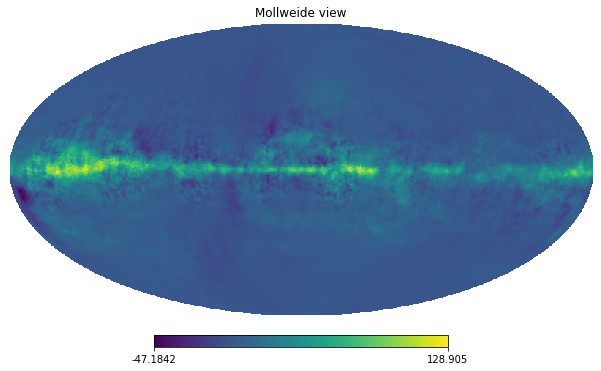

In [13]:
hp.mollview(component_maps[0, :, 0])

In [14]:

func = lambda beta: - lnP(parameters, beta_d=beta[0], beta_s=beta[1])
gfunc = grad(func)
hfunc = hessian(func)

In [16]:
res = minimize(func, np.array([1.4, -3.4]), method='Nelder-Mead')

In [17]:
print(res)

final_simplex: (array([[ 1.53581852, -3.05095459],
       [ 1.53581813, -3.05095654],
       [ 1.53581851, -3.05095641]]), array([-4.69402903e+09, -4.69402903e+09, -4.69402903e+09]))
           fun: -4694029031.5408
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 42
        status: 0
       success: True
             x: array([ 1.53581852, -3.05095459])


In [22]:
ndim, nwalkers = 2, 10
key = jax.random.PRNGKey(748)
p0 = 0.1 * jax.random.normal(key, shape=(nwalkers, ndim)) * np.array([1.5, -3.])[None, :]
func = lambda beta: lnP(parameters, beta_d=beta[0], beta_s=beta[1])
sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
sampler.run_mcmc(p0, 1000)

State([[-3.06666445  1.28599809]
 [ 1.53965819 -3.0095626 ]
 [ 1.53959409 -3.00951134]
 [-3.06608729  1.28602149]
 [-3.06646796  1.28596868]
 [ 1.53965534 -3.00956017]
 [-3.06631069  1.28599515]
 [-3.06616908  1.28598907]
 [-3.06617492  1.28608233]
 [-3.06618653  1.28599581]], log_prob=[4.69353944e+09 4.69401456e+09 4.69401456e+09 4.69353944e+09
 4.69353944e+09 4.69401456e+09 4.69353944e+09 4.69353944e+09
 4.69353943e+09 4.69353944e+09], blobs=None, random_state=('MT19937', array([ 245232326,  868932757,  295936794, 2615368476,  883983253,
       2770981816,  355226241,  405768441, 2870576555, 3808906054,
       3866131886, 3625711643,  358863451, 3647227405, 3145940965,
       3246603617, 2579295515,  462629413, 2282201255, 3676922982,
       3266920634,  479866036, 1524840627, 3441964842, 3651544657,
       1286457823, 3257129294,  948837588, 1082506552, 4170444541,
       1843738325, 3815721386, 3524167894, 4237706354, 1515833359,
        335031224, 3128697080, 1691415979,  65100567

In [43]:
chain = sampler.get_chain(discard=100)


In [ ]:
chain.shape
chain = chain.flatten().reshape((-1, 2))
print(chain[:, 0])

In [26]:
import corner

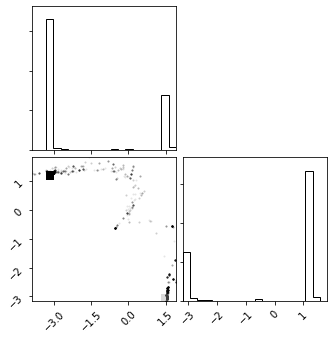

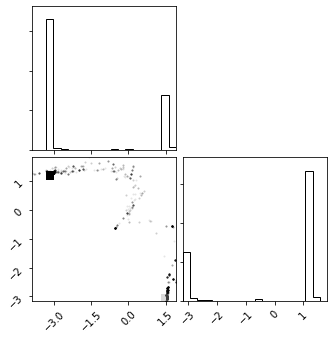

In [36]:
corner.corner(chain)

In [ ]:
comps = lnP.get_amplitude_expectation(parameters)
print(comps.shape)

In [ ]:
hp.mollview((comps[1, 1, :]))

In [ ]:
hp.nside2npix(nside)